# Building a Smart system based on Deep Convolutional Neural Networks to classify Trash

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras import models
from keras.optimizers import Adagrad
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# for reproducibility
np.random.seed(78)

Using TensorFlow backend.


In [ ]:
# Input image dimensions
img_rows, img_cols, img_chans = 384, 512, 3
input_shape = (img_rows, img_cols, img_chans)
batch_size = 8
num_classes = 2
epochs = 2000
data_augmentation = True

In [2]:
def train(x_train, x_test, y_train, y_test):
    
    #Loading the VGG model
    vgg_conv = VGG16(weights='imagenet', include_top=False,  input_shape=input_shape)
    
    for i in range(8):
        #removing the last layers  
        vgg_conv.layers.pop() 
    
    
    # Freezing all layers
    for layer in vgg_conv.layers[:]:
        layer.trainable = False
     
    # Building Deep learning model
    model = models.Sequential()
     
    # Adding the vgg model
    model.add(vgg_conv)
     
    # Adding new layers
    model.add(Flatten())
    model.add(Dense(350, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(350, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
     
    model.compile(loss='binary_crossentropy', optimizer=Adagrad(lr=1e-5, decay=1e-6), metrics=['accuracy'])
    
    """
    files = glob('Model2**')
    print(files)
    list_models=[]
    for  model_ in files:
        list_models.append(float(model_[:-5].split('=')[1]))
        
    index = np.argmin(list_models)
    load_model = files[index]
    print(load_model)

    if load_model is not None:
            model.load_weights(load_model)
            print("weights are loaded")
    else:
            print("weights are None")
    """       
    
    call =  [                  
                                    EarlyStopping(monitor='val_loss',  patience=20, verbose=1,  mode='auto'),
            ]
    
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset   
        samplewise_center=False,  # set each sample mean to 0   
        featurewise_std_normalization=False,  # divide inputs by std of the dataset   
        samplewise_std_normalization=False,  # divide each input by its std  
        zca_whitening=False,  # apply ZCA whitening     
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)  <<1    0 => 30
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.2,  # set range for random shear  <<3<<4  0 => 0.1 => 0.2
        zoom_range=0.3,  # set range for random zoom    <<1<<2<<3   0 => 0.1 => 0.2 =>0.3 
        channel_shift_range=0.2,  # set range for random channel shifts     <<5<<6   0.=>0.1=>0.2
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"     
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images    <<1    false => True
        # set rescaling factor (applied before any other transformation)
        rescale=None,   
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
        print("steps_per_epoch (nbr of samples per epoch):", int(len(x_train)/batch_size))
        # Fit the model on the batches generated by datagen.flow().
        history = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),steps_per_epoch = 800,
                            epochs=2000,
                            validation_data=(x_test, y_test),
                            workers=10, callbacks = call)
        
        weights = '{}.hdf5'.format('Model3_adagrad_'+'val_acc:'+str(round(history.history['val_acc'][-1],3))+' val_loss='+str(round(history.history['val_loss'][-1],3)))
        model.save_weights(weights)
        print ('Model saved.')
        
        score = model.evaluate(x_test, y_test,batch_size=10, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epoch = range(len(acc))

        plt.plot(epoch, acc, 'b', label='Training acc')
        plt.plot(epoch, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epoch, loss, 'b', label='Training loss')
        plt.plot(epoch, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

In [ ]:
def test(x_test):
    
    image = np.expand_dims((x_test[58] - np.mean(x_test))/ np.std(x_test), axis=0)

    plt.imshow(x_test[58])
    plt.show()

    out = model.predict(x_test[58])
    out = np.argmax(out)

    if out == 1:
            label = 'plastic'
    else:
            label = 'glass'

    return out, label

x_train shape: (688, 384, 512, 3)
688 train samples
295 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Using real-time data augmentation.
steps_per_epoch (nbr of samples per epoch): 86
Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
200/200 [==============================] - 31s 153ms/step - loss: 0.7033 - acc: 0.5275 - val_loss: 0.6807 - val_acc: 0.5763
Epoch 2/2000
200/200 [==============================] - 25s 125ms/step - loss: 0.6780 - acc: 0.5737 - val_loss: 0.6638 - val_acc: 0.6102
Epoch 3/2000
200/200 [==============================] - 25s 126ms/step - loss: 0.6672 - acc: 0.5859 - val_loss: 0.6592 - val_acc: 0.6085
Epoch 4/2000
200/200 [==============================] - 25s 125ms/step - loss: 0.6566 - acc: 0.6109 - val_loss: 0.6518 - val_acc: 0.6373
Epoch 5/2000
200/200 [==============================] - 26s 128ms/

200/200 [==============================] - 25s 127ms/step - loss: 0.4413 - acc: 0.8166 - val_loss: 0.4661 - val_acc: 0.8034
Epoch 112/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.4575 - acc: 0.7950 - val_loss: 0.4655 - val_acc: 0.8017
Epoch 113/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4572 - acc: 0.7969 - val_loss: 0.4645 - val_acc: 0.8017
Epoch 114/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.4422 - acc: 0.8181 - val_loss: 0.4629 - val_acc: 0.8034
Epoch 115/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4542 - acc: 0.7956 - val_loss: 0.4623 - val_acc: 0.8034
Epoch 116/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4596 - acc: 0.8059 - val_loss: 0.4628 - val_acc: 0.8034
Epoch 117/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4589 - acc: 0.8038 - val_loss: 0.4624 - val_acc: 0.8000
Epoch 118/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.4206 - acc: 0.8316 - val_loss: 0.4380 - val_acc: 0.8136
Epoch 171/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.4154 - acc: 0.8269 - val_loss: 0.4381 - val_acc: 0.8186
Epoch 172/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4177 - acc: 0.8219 - val_loss: 0.4363 - val_acc: 0.8136
Epoch 173/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.4231 - acc: 0.8253 - val_loss: 0.4357 - val_acc: 0.8136
Epoch 174/2000
200/200 [==============================] - 25s 126ms/step - loss: 0.4087 - acc: 0.8375 - val_loss: 0.4353 - val_acc: 0.8136
Epoch 175/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4183 - acc: 0.8256 - val_loss: 0.4372 - val_acc: 0.8153
Epoch 176/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.4297 - acc: 0.8197 - val_loss: 0.4386 - val_acc: 0.8203
Epoch 177/2000
200/200 [==================

200/200 [==============================] - 25s 127ms/step - loss: 0.3934 - acc: 0.8462 - val_loss: 0.4182 - val_acc: 0.8220
Epoch 230/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3975 - acc: 0.8300 - val_loss: 0.4188 - val_acc: 0.8220
Epoch 231/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3894 - acc: 0.8447 - val_loss: 0.4186 - val_acc: 0.8237
Epoch 232/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3849 - acc: 0.8459 - val_loss: 0.4182 - val_acc: 0.8237
Epoch 233/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.4037 - acc: 0.8291 - val_loss: 0.4193 - val_acc: 0.8186
Epoch 234/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3981 - acc: 0.8366 - val_loss: 0.4189 - val_acc: 0.8186
Epoch 235/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3854 - acc: 0.8409 - val_loss: 0.4182 - val_acc: 0.8203
Epoch 236/2000
200/200 [==================

200/200 [==============================] - 26s 129ms/step - loss: 0.3658 - acc: 0.8547 - val_loss: 0.4040 - val_acc: 0.8237
Epoch 289/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3877 - acc: 0.8416 - val_loss: 0.4022 - val_acc: 0.8254
Epoch 290/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3686 - acc: 0.8556 - val_loss: 0.4019 - val_acc: 0.8254
Epoch 291/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3780 - acc: 0.8522 - val_loss: 0.4028 - val_acc: 0.8237
Epoch 292/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3791 - acc: 0.8469 - val_loss: 0.4044 - val_acc: 0.8254
Epoch 293/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3743 - acc: 0.8506 - val_loss: 0.4028 - val_acc: 0.8237
Epoch 294/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3699 - acc: 0.8559 - val_loss: 0.4046 - val_acc: 0.8271
Epoch 295/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.3445 - acc: 0.8719 - val_loss: 0.3926 - val_acc: 0.8305
Epoch 348/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3658 - acc: 0.8522 - val_loss: 0.3922 - val_acc: 0.8305
Epoch 349/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3552 - acc: 0.8641 - val_loss: 0.3918 - val_acc: 0.8339
Epoch 350/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3506 - acc: 0.8650 - val_loss: 0.3927 - val_acc: 0.8305
Epoch 351/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3673 - acc: 0.8538 - val_loss: 0.3931 - val_acc: 0.8288
Epoch 352/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3581 - acc: 0.8609 - val_loss: 0.3935 - val_acc: 0.8271
Epoch 353/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3569 - acc: 0.8613 - val_loss: 0.3926 - val_acc: 0.8305
Epoch 354/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.3494 - acc: 0.8663 - val_loss: 0.3831 - val_acc: 0.8339
Epoch 407/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3552 - acc: 0.8594 - val_loss: 0.3822 - val_acc: 0.8339
Epoch 408/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3525 - acc: 0.8584 - val_loss: 0.3829 - val_acc: 0.8339
Epoch 409/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3404 - acc: 0.8762 - val_loss: 0.3821 - val_acc: 0.8356
Epoch 410/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3496 - acc: 0.8672 - val_loss: 0.3836 - val_acc: 0.8322
Epoch 411/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3356 - acc: 0.8788 - val_loss: 0.3832 - val_acc: 0.8339
Epoch 412/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3565 - acc: 0.8575 - val_loss: 0.3839 - val_acc: 0.8322
Epoch 413/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.3384 - acc: 0.8769 - val_loss: 0.3750 - val_acc: 0.8390
Epoch 466/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3335 - acc: 0.8766 - val_loss: 0.3747 - val_acc: 0.8424
Epoch 467/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3322 - acc: 0.8728 - val_loss: 0.3758 - val_acc: 0.8373
Epoch 468/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3332 - acc: 0.8791 - val_loss: 0.3753 - val_acc: 0.8373
Epoch 469/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3468 - acc: 0.8581 - val_loss: 0.3757 - val_acc: 0.8373
Epoch 470/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3287 - acc: 0.8697 - val_loss: 0.3750 - val_acc: 0.8390
Epoch 471/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3307 - acc: 0.8772 - val_loss: 0.3750 - val_acc: 0.8373
Epoch 472/2000
200/200 [==================

200/200 [==============================] - 26s 129ms/step - loss: 0.3242 - acc: 0.8844 - val_loss: 0.3701 - val_acc: 0.8373
Epoch 525/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3289 - acc: 0.8744 - val_loss: 0.3691 - val_acc: 0.8390
Epoch 526/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3199 - acc: 0.8816 - val_loss: 0.3692 - val_acc: 0.8390
Epoch 527/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3194 - acc: 0.8828 - val_loss: 0.3680 - val_acc: 0.8407
Epoch 528/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3273 - acc: 0.8744 - val_loss: 0.3696 - val_acc: 0.8390
Epoch 529/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3326 - acc: 0.8756 - val_loss: 0.3693 - val_acc: 0.8390
Epoch 530/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3266 - acc: 0.8775 - val_loss: 0.3696 - val_acc: 0.8407
Epoch 531/2000
200/200 [==================

200/200 [==============================] - 25s 127ms/step - loss: 0.3299 - acc: 0.8719 - val_loss: 0.3636 - val_acc: 0.8424
Epoch 584/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3122 - acc: 0.8875 - val_loss: 0.3624 - val_acc: 0.8441
Epoch 585/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3220 - acc: 0.8778 - val_loss: 0.3622 - val_acc: 0.8441
Epoch 586/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3150 - acc: 0.8797 - val_loss: 0.3625 - val_acc: 0.8441
Epoch 587/2000
200/200 [==============================] - 26s 130ms/step - loss: 0.3164 - acc: 0.8747 - val_loss: 0.3614 - val_acc: 0.8458
Epoch 588/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3289 - acc: 0.8788 - val_loss: 0.3609 - val_acc: 0.8475
Epoch 589/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3176 - acc: 0.8812 - val_loss: 0.3619 - val_acc: 0.8441
Epoch 590/2000
200/200 [==================

200/200 [==============================] - 25s 127ms/step - loss: 0.3168 - acc: 0.8812 - val_loss: 0.3564 - val_acc: 0.8475
Epoch 643/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3084 - acc: 0.8938 - val_loss: 0.3560 - val_acc: 0.8475
Epoch 644/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3092 - acc: 0.8850 - val_loss: 0.3561 - val_acc: 0.8475
Epoch 645/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3021 - acc: 0.8887 - val_loss: 0.3564 - val_acc: 0.8475
Epoch 646/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3087 - acc: 0.8866 - val_loss: 0.3566 - val_acc: 0.8475
Epoch 647/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3182 - acc: 0.8788 - val_loss: 0.3561 - val_acc: 0.8475
Epoch 648/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3109 - acc: 0.8850 - val_loss: 0.3571 - val_acc: 0.8475
Epoch 649/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.3032 - acc: 0.8906 - val_loss: 0.3521 - val_acc: 0.8458
Epoch 702/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3001 - acc: 0.8869 - val_loss: 0.3505 - val_acc: 0.8458
Epoch 703/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3097 - acc: 0.8837 - val_loss: 0.3516 - val_acc: 0.8458
Epoch 704/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2974 - acc: 0.8884 - val_loss: 0.3521 - val_acc: 0.8458
Epoch 705/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.3033 - acc: 0.8909 - val_loss: 0.3520 - val_acc: 0.8458
Epoch 706/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.3036 - acc: 0.8850 - val_loss: 0.3504 - val_acc: 0.8458
Epoch 707/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3079 - acc: 0.8853 - val_loss: 0.3511 - val_acc: 0.8458
Epoch 708/2000
200/200 [==================

200/200 [==============================] - 26s 128ms/step - loss: 0.3068 - acc: 0.8825 - val_loss: 0.3464 - val_acc: 0.8441
Epoch 761/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2894 - acc: 0.9000 - val_loss: 0.3468 - val_acc: 0.8441
Epoch 762/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.3012 - acc: 0.8884 - val_loss: 0.3463 - val_acc: 0.8441
Epoch 763/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.2956 - acc: 0.8919 - val_loss: 0.3467 - val_acc: 0.8458
Epoch 764/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2970 - acc: 0.8897 - val_loss: 0.3455 - val_acc: 0.8475
Epoch 765/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2894 - acc: 0.8941 - val_loss: 0.3466 - val_acc: 0.8458
Epoch 766/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2833 - acc: 0.9025 - val_loss: 0.3467 - val_acc: 0.8458
Epoch 767/2000
200/200 [==================

200/200 [==============================] - 26s 129ms/step - loss: 0.2963 - acc: 0.8909 - val_loss: 0.3445 - val_acc: 0.8475
Epoch 820/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.2863 - acc: 0.9006 - val_loss: 0.3439 - val_acc: 0.8458
Epoch 821/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2959 - acc: 0.8916 - val_loss: 0.3438 - val_acc: 0.8458
Epoch 822/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2950 - acc: 0.8875 - val_loss: 0.3442 - val_acc: 0.8475
Epoch 823/2000
200/200 [==============================] - 26s 129ms/step - loss: 0.2967 - acc: 0.8884 - val_loss: 0.3445 - val_acc: 0.8475
Epoch 824/2000
200/200 [==============================] - 25s 127ms/step - loss: 0.2871 - acc: 0.8941 - val_loss: 0.3440 - val_acc: 0.8475
Epoch 825/2000
200/200 [==============================] - 26s 128ms/step - loss: 0.2792 - acc: 0.9034 - val_loss: 0.3433 - val_acc: 0.8458
Epoch 826/2000
200/200 [==================

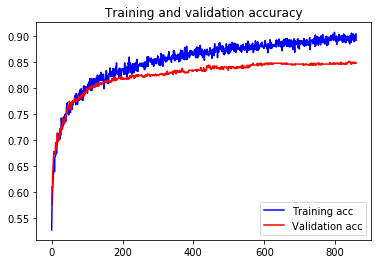

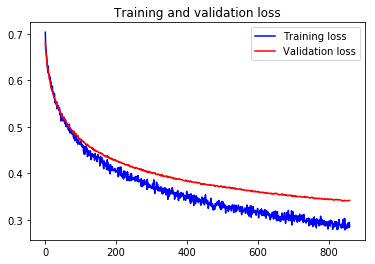

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


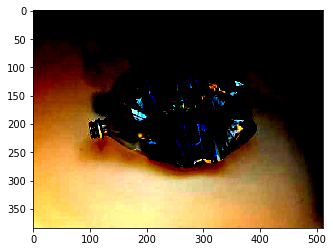

prediction :  1 =>  plastic


In [3]:
train()

In [ ]:
if __name__ == "__main__":   
    
    # Load all images
    all_images_array = np.load('all_images_array.npy')

    # load the the class labels
    all_labels = np.load('all_labels.npy')

    # Split the dataset into train and test sets, with percentage of splitting = 70 / 30 respectively
    x_train, x_test, y_train, y_test = train_test_split(all_images_array, all_labels, test_size=0.30, shuffle=True, random_state=78)

    # Data normalization to convert features to the same scale
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255

    x_train = (x_train - np.mean(x_train)) / np.std(x_train)
    x_test  = (x_test - np.mean(x_test)) / np.std(x_test)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # convert class vectors to One-hot encoding
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    train(x_train, x_test, y_train, y_test)
    
    prediction, label = test(x_test)
    
    print('The prediction of this object is:', prediction, '=> ', label)

In [ ]:
#Workers = 8
#step_per_epoch 100:
#Test loss: 0.34983771067049546
#Test accuracy: 0.8220338942640919

#step_per_epoch 200: epoch=>72
#Test loss: 0.28055439813662386
#Test accuracy: 0.8932203276682709

#step_per_epoch 400: epoch=>12 continous
#Test loss: 0.2784507023328442
#Test accuracy: 0.8949152453471039

#step_per_epoch 800: epoch=>9 continous
#Test loss: 0.2843580770669347
#Test accuracy: 0.9050847372766269

#==========================================
#Workers = 32
#step_per_epoch 100:  epoch=>10 continous
#Test loss: 0.2690500178200714
#Test accuracy: 0.9033898216182903

#step_per_epoch 200:  epoch=>18 continous
#Test loss: 0.2979729557252031
#Test accuracy: 0.9050847372766269

#step_per_epoch 400: epoch=>10 continous
#Test loss: 0.2838988147234007
#Test accuracy: 0.9067796549554599

#step_per_epoch 400: epoch=>6 continous
#Test loss: 0.2930123057468968
#Test accuracy: 0.9101694842516366

#having nbr of worker=32 and step_per_epoch=800 makes the memory overwhelms